# 1.  Imports and Environment Setup

Importing all necessary libraries for data processing, visualization, machine learning models, dimensionality reduction, and explainability.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# ML models & utils
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

# XGBoost & SHAP
import xgboost as xgb
import shap

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

shap.initjs()


# 2. Data Loading & Preprocessing

* Load training and testing gene expression datasets.

In [2]:
# [2] Data Load
labels_map = {'ALL': 0, 'AML': 1}
true_labels_df = pd.read_csv("/kaggle/input/gene-expression/actual.csv").replace(labels_map)
external_data = pd.read_csv("/kaggle/input/gene-expression/data_set_ALL_AML_independent.csv")
training_data = pd.read_csv("/kaggle/input/gene-expression/data_set_ALL_AML_train.csv")

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


* Preprocess and transpose data to have samples as rows.

In [3]:
# Drop 'call' columns
train_cols = [col for col in training_data.columns if "call" not in col]
test_cols = [col for col in external_data.columns if "call" not in col]
training_data = training_data[train_cols]
external_data = external_data[test_cols]

# Reordering
ordered_train_cols = ['Gene Description', 'Gene Accession Number'] + [str(i) for i in range(1, 39)]
ordered_test_cols = ['Gene Description', 'Gene Accession Number'] + [str(i) for i in range(39, 73)]
training_data = training_data.reindex(columns=ordered_train_cols)
external_data = external_data.reindex(columns=ordered_test_cols)

# Transpose & Clean
X_train = training_data.T
X_test = external_data.T
X_train.columns = X_train.iloc[1]
X_test.columns = X_test.iloc[1]
X_train = X_train.drop(['Gene Description', 'Gene Accession Number']).apply(pd.to_numeric).reset_index(drop=True)
X_test = X_test.drop(['Gene Description', 'Gene Accession Number']).apply(pd.to_numeric).reset_index(drop=True)

* Map labels to numeric format for classification.

In [4]:
# Labels
train_labels = true_labels_df[true_labels_df.patient <= 38].reset_index(drop=True)
test_labels = true_labels_df[true_labels_df.patient > 38].reset_index(drop=True)

In [5]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train labels:\n", train_labels['cancer'].value_counts())
print("Test labels:\n", test_labels['cancer'].value_counts())

Train shape: (38, 7129)
Test shape: (34, 7129)
Train labels:
 cancer
0    27
1    11
Name: count, dtype: int64
Test labels:
 cancer
0    20
1    14
Name: count, dtype: int64


# 3.  PCA Before Training

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [7]:
print(f"\n PCA reduced dimensions: {X_train_pca.shape[1]}")


 PCA reduced dimensions: 32


# 4. Classification Models

Training multiple classifiers including XGBoost, Decision Tree, Random Forest, and Logistic Regression to evaluate accuracy on unseen data.


 XGBoost (PCA) Accuracy: 0.618
 XGBoost (PCA) Classification Report:
               precision    recall  f1-score   support

         ALL       0.61      1.00      0.75        20
         AML       1.00      0.07      0.13        14

    accuracy                           0.62        34
   macro avg       0.80      0.54      0.44        34
weighted avg       0.77      0.62      0.50        34



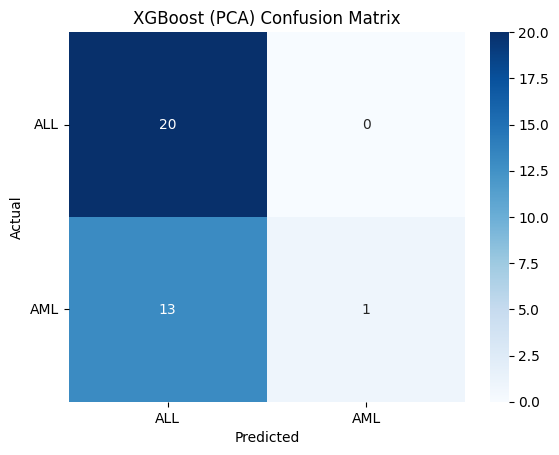


 Decision Tree (PCA) Accuracy: 0.706
 Decision Tree (PCA) Classification Report:
               precision    recall  f1-score   support

         ALL       0.67      1.00      0.80        20
         AML       1.00      0.29      0.44        14

    accuracy                           0.71        34
   macro avg       0.83      0.64      0.62        34
weighted avg       0.80      0.71      0.65        34



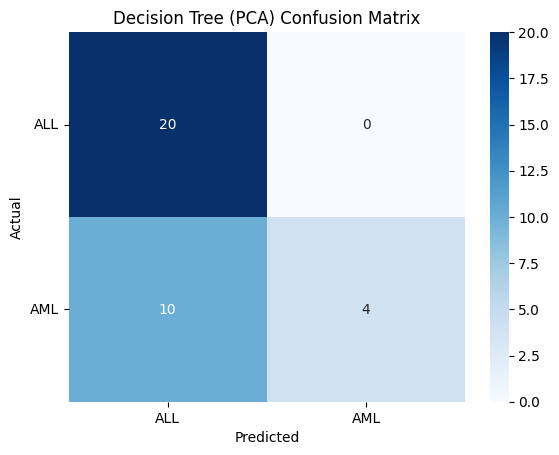


 Random Forest (PCA) Accuracy: 0.824
 Random Forest (PCA) Classification Report:
               precision    recall  f1-score   support

         ALL       0.79      0.95      0.86        20
         AML       0.90      0.64      0.75        14

    accuracy                           0.82        34
   macro avg       0.85      0.80      0.81        34
weighted avg       0.84      0.82      0.82        34



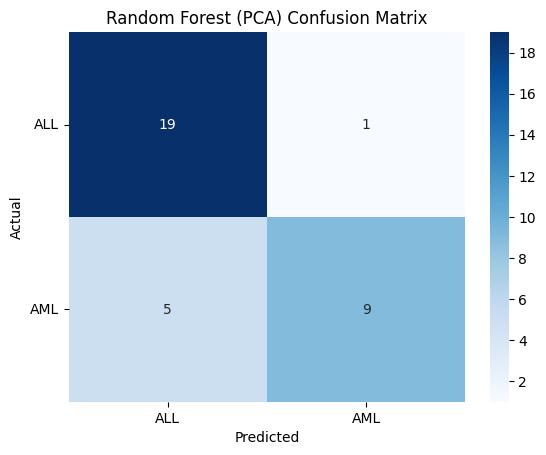


 Logistic Regression (PCA) Accuracy: 0.824
 Logistic Regression (PCA) Classification Report:
               precision    recall  f1-score   support

         ALL       0.77      1.00      0.87        20
         AML       1.00      0.57      0.73        14

    accuracy                           0.82        34
   macro avg       0.88      0.79      0.80        34
weighted avg       0.86      0.82      0.81        34



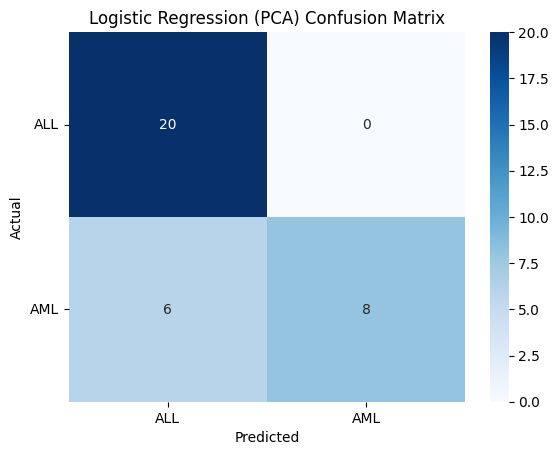

In [8]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"\n {model_name} Accuracy: {acc:.3f}")
    print(f" {model_name} Classification Report:\n", classification_report(y_test, preds, target_names=["ALL", "AML"]))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(ticks=[0.5, 1.5], labels=['ALL', 'AML'])
    plt.yticks(ticks=[0.5, 1.5], labels=['ALL', 'AML'], rotation=0)
    plt.show()

xgb_clf = xgb.XGBClassifier(random_state=0)
evaluate_model(xgb_clf, X_train_pca, train_labels['cancer'], X_test_pca, test_labels['cancer'], "XGBoost (PCA)")

dt_clf = DecisionTreeClassifier(random_state=0)
evaluate_model(dt_clf, X_train_pca, train_labels['cancer'], X_test_pca, test_labels['cancer'], "Decision Tree (PCA)")

rf_params = {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 60}
rf_clf = RandomForestClassifier(random_state=0, **rf_params)
evaluate_model(rf_clf, X_train_pca, train_labels['cancer'], X_test_pca, test_labels['cancer'], "Random Forest (PCA)")

lr_clf = LogisticRegression(random_state=0, max_iter=1000)
evaluate_model(lr_clf, X_train_pca, train_labels['cancer'], X_test_pca, test_labels['cancer'], "Logistic Regression (PCA)")

# 5. Decision Tree Visualization

Visualizing the trained Decision Tree model for interpretability.

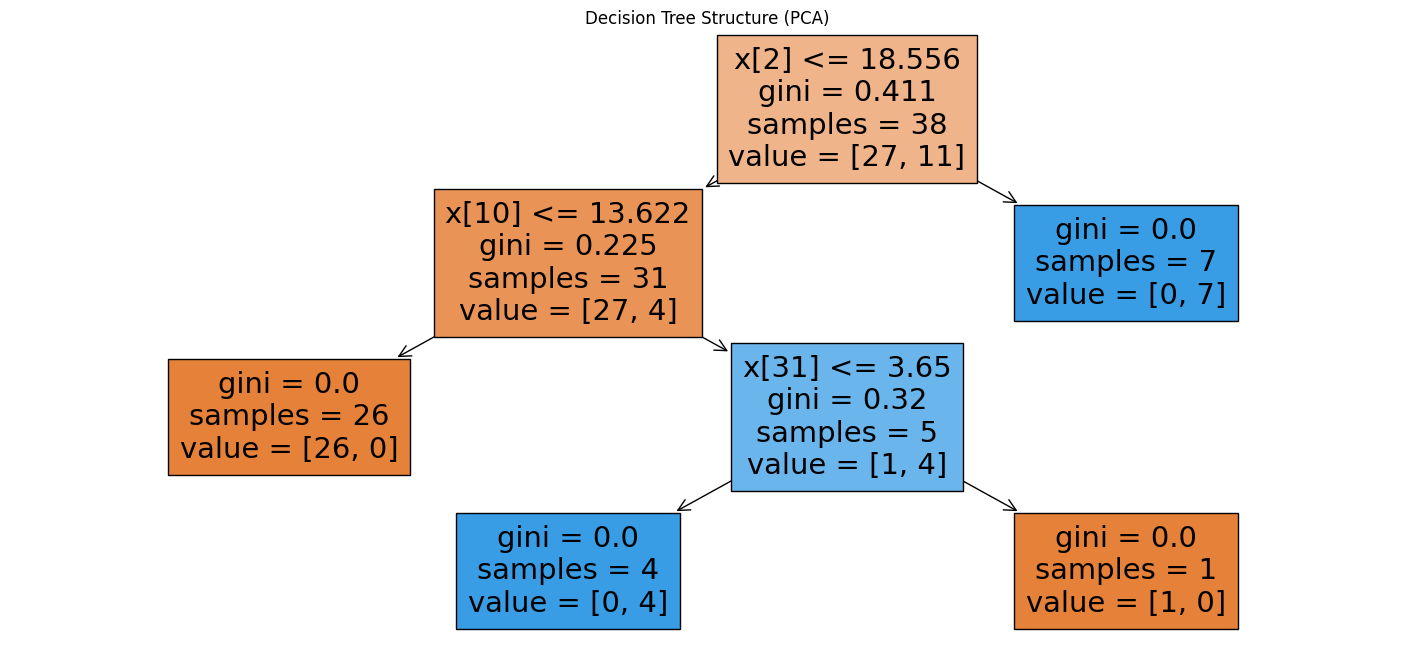

In [9]:
plt.figure(figsize=(18, 8))
plot_tree(dt_clf, filled=True)
plt.title("Decision Tree Structure (PCA)")
plt.show()

# 6. SHAP for Model Interpretation

Using SHAP values to interpret feature contributions from Random Forest.

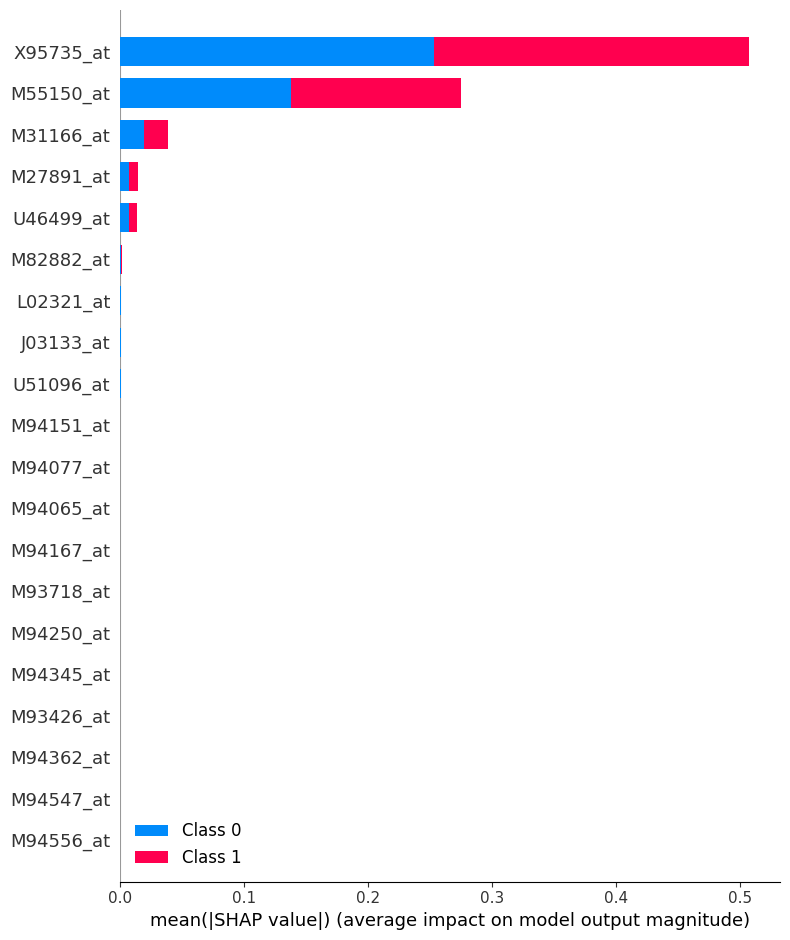

Top 10 SHAP features:
Gene Accession Number
X95735_at    0.253457
M55150_at    0.137618
M31166_at    0.019407
M27891_at    0.007447
U46499_at    0.006920
M82882_at    0.000778
L02321_at    0.000572
J03133_at    0.000517
U51096_at    0.000437
X87767_at    0.000000
dtype: float64


In [10]:
rf_clf_original = RandomForestClassifier(random_state=0, **rf_params)
rf_clf_original.fit(X_train, train_labels['cancer'])

shap_explainer_rf = shap.TreeExplainer(rf_clf_original)
shap_vals_rf = shap_explainer_rf.shap_values(X_test)

shap.summary_plot(shap_vals_rf, X_test, show=True)

shap_mean_abs = np.abs(shap_vals_rf[1]).mean(axis=0)
shap_feature_importance = pd.Series(shap_mean_abs, index=X_test.columns)
print("Top 10 SHAP features:")
print(shap_feature_importance.sort_values(ascending=False).head(10))

# 7. Top Influential Principal Components in Logistic Regression

This plot highlights the top 10 principal components that most influence the logistic regression model's predictions after PCA. It shows which compressed features contribute most to distinguishing between ALL and AML leukemia types.

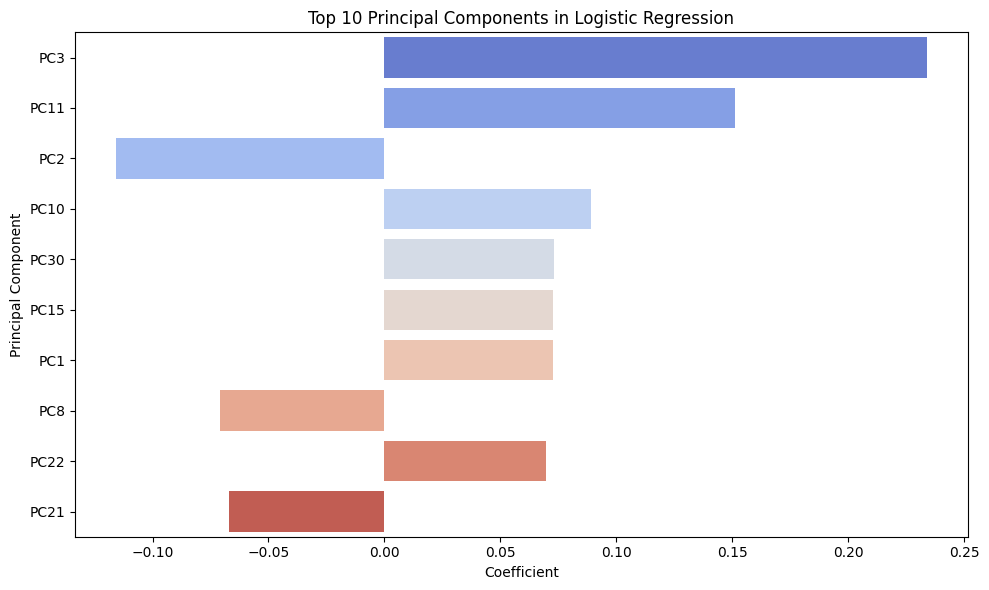

In [11]:
lr_pca_coeffs = lr_clf.coef_[0]
pc_names = [f'PC{i+1}' for i in range(len(lr_pca_coeffs))]

lr_pca_df = pd.DataFrame({'Principal Component': pc_names, 'Coefficient': lr_pca_coeffs})

top_pcs = lr_pca_df.reindex(lr_pca_df.Coefficient.abs().sort_values(ascending=False).index).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_pcs, x='Coefficient', y='Principal Component', palette='coolwarm')
plt.title('Top 10 Principal Components in Logistic Regression')
plt.tight_layout()
plt.show()

# 8. Clustering and Purity Evaluation

Applying unsupervised clustering algorithms and computing purity against true labels to evaluate grouping quality.

In [12]:
def compute_purity(true_y, pred_labels):
    cm = confusion_matrix(pred_labels, true_y)
    return np.sum(np.amax(cm, axis=1)) / np.sum(cm)

kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train_pca)
print(f"KMeans Purity (PCA): {compute_purity(train_labels['cancer'], kmeans.labels_):.3f}")

agg = AgglomerativeClustering(n_clusters=2).fit(X_train_pca)
print(f"Agglomerative Clustering Purity (PCA): {compute_purity(train_labels['cancer'], agg.labels_):.3f}")

spec = SpectralClustering(n_clusters=2, random_state=0).fit(X_train_pca)
print(f"Spectral Clustering Purity (PCA): {compute_purity(train_labels['cancer'], spec.labels_):.3f}")

KMeans Purity (PCA): 0.737
Agglomerative Clustering Purity (PCA): 0.737
Spectral Clustering Purity (PCA): 0.711


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
Graph is not fully connected, spectral embedding may not work as expected.


# 9. PCA Visualization

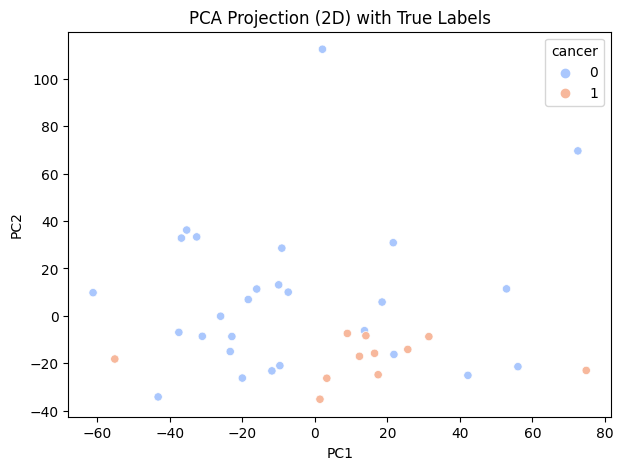

In [13]:
pca_features = PCA(n_components=2).fit_transform(X_train_scaled)

plt.figure(figsize=(7, 5))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=train_labels['cancer'], palette="coolwarm")
plt.title("PCA Projection (2D) with True Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 10. PCA Explained Variance Plot

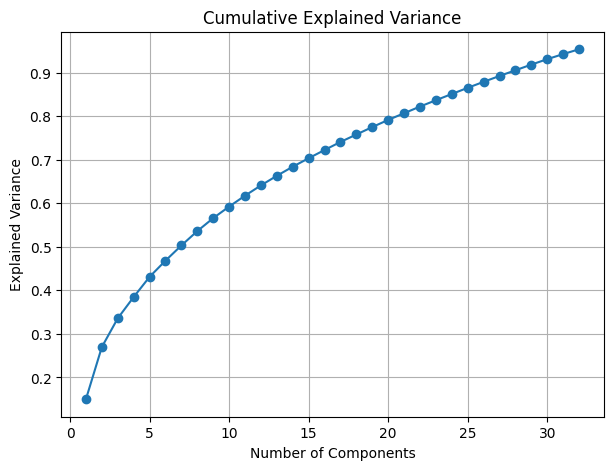

In [14]:
expl_var_ratio = pca.explained_variance_ratio_
cum_var_ratio = np.cumsum(expl_var_ratio)

plt.figure(figsize=(7, 5))
plt.plot(range(1, len(cum_var_ratio)+1), cum_var_ratio, marker='o')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.grid(True)
plt.show()

# Final Summary

In [15]:
print("\nSummary of Accuracy and Clustering Purity with PCA")
print(f"XGBoost (PCA) Accuracy: {accuracy_score(test_labels['cancer'], xgb.XGBClassifier(random_state=0).fit(X_train_pca, train_labels['cancer']).predict(X_test_pca)):.3f}")
print(f"Random Forest (PCA) Accuracy: {accuracy_score(test_labels['cancer'], RandomForestClassifier(random_state=0, **rf_params).fit(X_train_pca, train_labels['cancer']).predict(X_test_pca)):.3f}")
print(f"Logistic Regression (PCA) Accuracy: {accuracy_score(test_labels['cancer'], LogisticRegression(max_iter=1000).fit(X_train_pca, train_labels['cancer']).predict(X_test_pca)):.3f}")
print(f"Decision Tree (PCA) Accuracy: {accuracy_score(test_labels['cancer'], dt_clf.predict(X_test_pca)):.3f}")


Summary of Accuracy and Clustering Purity with PCA
XGBoost (PCA) Accuracy: 0.618
Random Forest (PCA) Accuracy: 0.824
Logistic Regression (PCA) Accuracy: 0.824
Decision Tree (PCA) Accuracy: 0.706


# 🧾 Final Report Link

[https://docs.google.com/document/d/1GIASXH-nphQOSH0WJ8mZQaI53_i7X9Q54xQxOS_PPDw/edit?usp=sharing](https://docs.google.com/document/d/1GIASXH-nphQOSH0WJ8mZQaI53_i7X9Q54xQxOS_PPDw/edit?usp=sharing)